### Purpose of notebook

This is a reworked and more concise version of my full notebook that only includes my final CellDrift/subsampling iteration that included up to 1000 cells per cell type/treatment/time point. This also goes through some collinearity, but more from the perspective of the poster where I mapped genes that were collinear with predictors instad of doing coinflipping (which can be accessed either through the main notebook or through the independent script).

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_squared_error, root_mean_squared_error, classification_report, f1_score, r2_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
import pandas as pd
import numpy as np
import re
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree, plot_importance
import time
import random
from scipy import stats
import igraph as ig

In [2]:
coefficients = pd.DataFrame()
timepoints = ['24', '48', '72']

for rep in range(1,11):
    for time in timepoints:
        temp_coeff = pd.read_csv(f'/lustre/scratch125/casm/team215mg/pg21_rotation/Coefficients_CellDrift/selection_rep_{rep}/Contrast_Coefficients_time_{time}.txt', sep = '\t')
        temp_coeff['contrast'] = temp_coeff['contrast'] + f'_{rep}'
        temp_coeff['time'] = time
        coefficients = pd.concat([coefficients, temp_coeff], ignore_index = True)

coefficients['cell_type'] = coefficients['cell_type'].str.split(',', n = 1).str.get(-1).str.split("'").str.get(-2)
coefficients['perturbation'] = coefficients['perturbation'].str.split(',', n = 1).str.get(0).str.split("'").str.get(-2)
coefficients['cell_type'] = coefficients['cell_type'].map({'Fetal':0, 'Stem':1, 'Cycling':2, 'Secretory':3, 'Stress':4, 'Respiration':5})

#coefficients = coefficients[coefficients['p_fdr'] < 0.05]
coefficients = coefficients[(coefficients['perturbation'] == 'MRTX1133_SHP099') | (coefficients['perturbation'] == 'MRTX1133_afatinib')]

coefficients

,contrast,cell_type,perturbation,mean,lci,uci,SE,z,p,p_fdr,pts_contrast,pts_reference,gene,time
1,Cycling_MRTX1133_SHP099-Cycling_DMSO_1,2,MRTX1133_SHP099,1.1908,1.8376,0.5441,0.3300,3.6088,0.0003,0.002662,0.219178,0.130000,ABAT,24
2,Cycling_MRTX1133_afatinib-Cycling_DMSO_1,2,MRTX1133_afatinib,1.2289,1.9590,0.4988,0.3725,3.2991,0.0010,0.006495,0.200000,0.130000,ABAT,24
6,Fetal_MRTX1133_SHP099-Fetal_DMSO_1,0,MRTX1133_SHP099,-0.2991,0.0966,-0.6948,0.2019,-1.4813,0.1385,0.271822,0.490000,0.360000,ABAT,24
7,Fetal_MRTX1133_afatinib-Fetal_DMSO_1,0,MRTX1133_afatinib,-0.3774,0.0459,-0.8008,0.2160,-1.7474,0.0806,0.185321,0.350000,0.360000,ABAT,24
11,Stem_MRTX1133_SHP099-Stem_DMSO_1,1,MRTX1133_SHP099,0.7952,1.3217,0.2686,0.2686,2.9600,0.0031,0.015878,0.280000,0.196667,ABAT,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808187,Respiration_MRTX1133_afatinib-Respiration_DMSO_10,5,MRTX1133_afatinib,0.0686,232860.8178,-232860.6806,118808.6878,0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
808191,Secretory_MRTX1133_SHP099-Secretory_DMSO_10,3,MRTX1133_SHP099,0.0557,281932.6542,-281932.5428,143845.8057,0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
808192,Secretory_MRTX1133_afatinib-Secretory_DMSO_10,3,MRTX1133_afatinib,-0.0390,691627.7387,-691627.8166,352877.7993,-0.0000,1.0000,1.000000,0.000000,0.000000,ZNF831,72
808196,Stress_MRTX1133_SHP099-Stress_DMSO_10,4,MRTX1133_SHP099,1.8791,4.2465,-0.4883,1.2079,1.5557,0.1198,1.000000,0.010000,0.003333,ZNF831,72


In [3]:
pivot = pd.read_csv('/lustre/scratch125/casm/team215mg/pg21_rotation/new_all_pivot.tsv', sep = '\t')

In [4]:
pivot_24 = pivot[pivot['time'] == 24]
pivot_48 = pivot[pivot['time'] == 48]
pivot_72 = pivot[pivot['time'] == 72]
y_24 = pivot_24['cell_type'].to_numpy()
y_48 = pivot_48['cell_type'].to_numpy()
y_72 = pivot_72['cell_type'].to_numpy()

In [5]:
for gene in np.unique(coefficients['gene']):
    pivot_24[f'{gene}_delta'] = pivot_48[f'{gene}_delta'].values
    #pivot_48[f'{gene}_delta'] = pivot_72[f'{gene}_delta'].values

/tmp/ipykernel_1397956/1463159500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_24[f'{gene}_delta'] = pivot_48[f'{gene}_delta'].values


In [6]:
pivot_24.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_24 = pivot_24.to_numpy()
pivot_48.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_48 = pivot_48.to_numpy()
pivot_72.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
X_72 = pivot_72.to_numpy()
X_48

/tmp/ipykernel_1397956/768850682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_24.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_1397956/768850682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_48.drop(['Unnamed: 0', 'contrast', 'cell_type', 'time'], axis = 1, inplace = True)
/tmp/ipykernel_1397956/768850682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_

array([[ 2.6378e+00,  2.8184e+00,  1.6958e+00, ..., -9.5950e-01,
         0.0000e+00,  0.0000e+00],
       [ 3.7563e+00,  2.7456e+00,  1.9147e+00, ..., -7.9000e-02,
        -1.0000e-04,  0.0000e+00],
       [ 5.1687e+00,  2.0573e+00,  1.7159e+00, ..., -1.2550e+00,
        -1.0000e-04,  0.0000e+00],
       ...,
       [ 1.7481e+00,  1.7535e+00,  4.0480e-01, ...,  1.8383e+00,
         2.7540e-01,  0.0000e+00],
       [ 2.1141e+00,  1.3700e-01,  2.4620e-01, ...,  2.8725e+00,
         2.6325e+00, -1.0000e-04],
       [ 3.4420e+00,  6.1380e-01,  4.6200e-02, ..., -5.1460e-01,
         2.1963e+00, -8.8300e-02]], shape=(120, 1796))

In [7]:
X_24_train, X_24_test, y_24_train, y_24_test = train_test_split(pivot_24, y_24, test_size = 0.2)
X_48_train, X_48_test, y_48_train, y_48_test = train_test_split(pivot_48, y_48, test_size = 0.2)
X_72_train, X_72_test, y_72_train, y_72_test = train_test_split(pivot_72, y_72, test_size = 0.2)

In [8]:
xgb_tuned = XGBClassifier(learning_rate = 0.2,
                          max_depth = 18,
                          n_estimators = 421,
                          subsample = 0.2,
                          reg_alpha = 0.2,
                          reg_lambda = 0,
                          early_stopping_rounds = 50)
xgb_tuned.fit(pivot_24, y_24, eval_set = [(pivot_24, y_24)])

[0]	validation_0-mlogloss:1.42041
[1]	validation_0-mlogloss:1.14916
[2]	validation_0-mlogloss:1.00153
[3]	validation_0-mlogloss:0.83583
[4]	validation_0-mlogloss:0.72753
[5]	validation_0-mlogloss:0.63618
[6]	validation_0-mlogloss:0.55590
[7]	validation_0-mlogloss:0.48835
[8]	validation_0-mlogloss:0.43045
[9]	validation_0-mlogloss:0.38613
[10]	validation_0-mlogloss:0.37322
[11]	validation_0-mlogloss:0.32348
[12]	validation_0-mlogloss:0.27714
[13]	validation_0-mlogloss:0.26545
[14]	validation_0-mlogloss:0.24463
[15]	validation_0-mlogloss:0.21909
[16]	validation_0-mlogloss:0.19929
[17]	validation_0-mlogloss:0.19373
[18]	validation_0-mlogloss:0.18104
[19]	validation_0-mlogloss:0.17224
[20]	validation_0-mlogloss:0.16182
[21]	validation_0-mlogloss:0.15423
[22]	validation_0-mlogloss:0.14504
[23]	validation_0-mlogloss:0.13996
[24]	validation_0-mlogloss:0.13604
[25]	validation_0-mlogloss:0.13009
[26]	validation_0-mlogloss:0.12769
[27]	validation_0-mlogloss:0.12075
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=421, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [9]:
predictions = xgb_tuned.predict(pivot_72)
accuracy = accuracy_score(y_72, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.00%


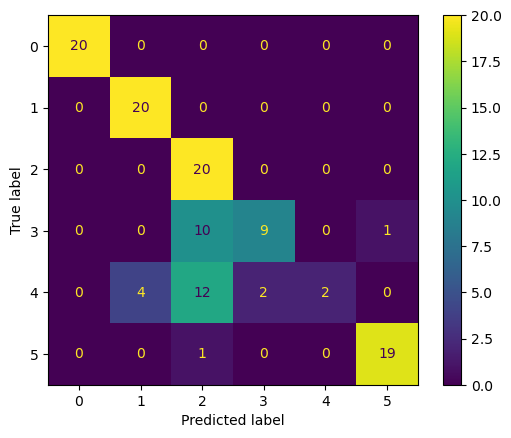

In [10]:
cm = confusion_matrix(y_72, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
selection = SelectFromModel(xgb_tuned, threshold = 0.005, prefit = True)
selected_dataset = selection.transform(pivot_72)
selected_X24 = selection.transform(pivot_24)

/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [12]:
xgb_tuned_new = XGBClassifier(learning_rate = 0.2,
                          max_depth = 15,
                          n_estimators = 421,
                          subsample = 0.2,
                          reg_alpha = 0.2,
                          reg_lambda = 0,
                          early_stopping_rounds = 50)
xgb_tuned_new.fit(selected_X24, y_24, eval_set = [(selected_X24, y_24)])

[0]	validation_0-mlogloss:1.42041
[1]	validation_0-mlogloss:1.14916
[2]	validation_0-mlogloss:1.00363
[3]	validation_0-mlogloss:0.83725
[4]	validation_0-mlogloss:0.72845
[5]	validation_0-mlogloss:0.63697
[6]	validation_0-mlogloss:0.55858
[7]	validation_0-mlogloss:0.49073
[8]	validation_0-mlogloss:0.42657
[9]	validation_0-mlogloss:0.37710
[10]	validation_0-mlogloss:0.35564
[11]	validation_0-mlogloss:0.30799
[12]	validation_0-mlogloss:0.26542
[13]	validation_0-mlogloss:0.25498
[14]	validation_0-mlogloss:0.23584
[15]	validation_0-mlogloss:0.21050
[16]	validation_0-mlogloss:0.19106
[17]	validation_0-mlogloss:0.18674
[18]	validation_0-mlogloss:0.17826
[19]	validation_0-mlogloss:0.17107
[20]	validation_0-mlogloss:0.15964
[21]	validation_0-mlogloss:0.15244
[22]	validation_0-mlogloss:0.14410
[23]	validation_0-mlogloss:0.13806
[24]	validation_0-mlogloss:0.13449
[25]	validation_0-mlogloss:0.12949
[26]	validation_0-mlogloss:0.12648
[27]	validation_0-mlogloss:0.11952
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=421, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
predictions_new = xgb_tuned_new.predict(selected_dataset)
accuracy_new = accuracy_score(y_72, predictions_new)
print("Accuracy: %.2f%%" % (accuracy_new * 100.0))

Accuracy: 76.67%


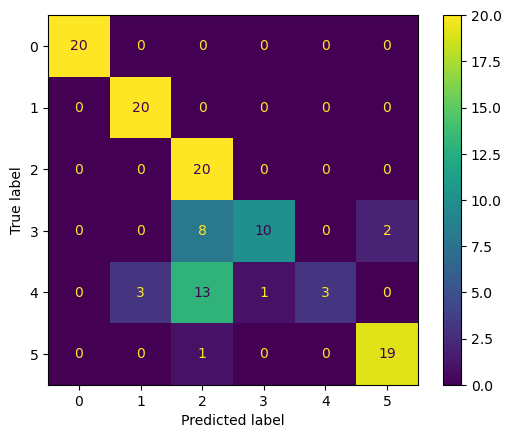

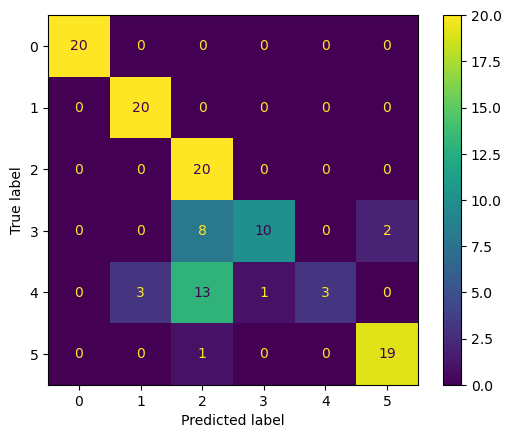

In [14]:
cm_new = confusion_matrix(y_72, predictions_new)

ConfusionMatrixDisplay(confusion_matrix=cm_new).plot()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_new)
disp.plot().figure_.savefig('tuned_model_cm.pdf')

In [15]:
features_24 = pd.DataFrame()
features_24['columns'] = pivot_24.columns
features_24['importances'] = xgb_tuned.feature_importances_
features_24.sort_values(by = 'importances', ascending = False, inplace = True)
features_24[features_24['importances'] >= 0.005].to_csv('feature_list_24.tsv', sep = '\t')

In [16]:
corr_matrix_24 = pivot_24.corr(method = 'pearson')
corr_matrix_24 = corr_matrix_24.pow(2)
corr_matrix_24 = corr_matrix_24.stack()
corr_matrix_24 = corr_matrix_24[((corr_matrix_24 > 0.7)) & (corr_matrix_24 != 1)]
corr_matrix_24 = corr_matrix_24.to_frame()

for feature in features_24[features_24['importances'] >= 0.005]['columns']:
    if len(corr_matrix_24[corr_matrix_24.index.get_level_values(0) == feature].index.get_level_values(1).values) > 0:
        print(f'Feature = {feature}, collinear genes = {corr_matrix_24[corr_matrix_24.index.get_level_values(0) == feature].index.get_level_values(1).values}')


Feature = AC113410_4, collinear genes = ['AC113410_4_delta']
Feature = ABAT, collinear genes = ['ASS1']
Feature = AL353138_1, collinear genes = ['AC093866_1' 'LINC01811' 'MDM2' 'PTCHD4']
Feature = AC007179_2, collinear genes = ['ALCAM' 'DKK4' 'FGF20' 'GRM8' 'ITPR2' 'NKD1' 'PROX1_AS1' 'SERPINI1' 'SYK'
 'AL136962_1_delta' 'NKD1_delta']
Feature = AC002451_1, collinear genes = ['HDAC9' 'SAMD4A' 'XACT']
Feature = AC008629_1, collinear genes = ['AC008629_1_delta']
Feature = AC138356_3, collinear genes = ['AL590434_1' 'HIST1H2BG' 'HIST1H4H' 'KIAA0319' 'MIR7_3HG' 'SH3GL2'
 'SNX31']
Feature = ASB4, collinear genes = ['FABP1']
Feature = AC114811_2, collinear genes = ['PROX1_AS1' 'SERPINI1' 'SYK']


In [17]:
xgb_tuned = XGBClassifier(learning_rate = 0.2,
                          max_depth = 18,
                          n_estimators = 421,
                          subsample = 0.2,
                          reg_alpha = 0.2,
                          reg_lambda = 0,
                          early_stopping_rounds = 50)
xgb_tuned.fit(pivot_72, y_72, eval_set = [(pivot_72, y_72)])

[0]	validation_0-mlogloss:1.37881
[1]	validation_0-mlogloss:1.11408
[2]	validation_0-mlogloss:0.95112
[3]	validation_0-mlogloss:0.80484
[4]	validation_0-mlogloss:0.70501
[5]	validation_0-mlogloss:0.61437
[6]	validation_0-mlogloss:0.52782
[7]	validation_0-mlogloss:0.46422
[8]	validation_0-mlogloss:0.42160
[9]	validation_0-mlogloss:0.37063
[10]	validation_0-mlogloss:0.35852
[11]	validation_0-mlogloss:0.31377
[12]	validation_0-mlogloss:0.27334
[13]	validation_0-mlogloss:0.26187
[14]	validation_0-mlogloss:0.24305
[15]	validation_0-mlogloss:0.21767
[16]	validation_0-mlogloss:0.20137
[17]	validation_0-mlogloss:0.19182
[18]	validation_0-mlogloss:0.18398
[19]	validation_0-mlogloss:0.16956
[20]	validation_0-mlogloss:0.15787
[21]	validation_0-mlogloss:0.14946
[22]	validation_0-mlogloss:0.14382
[23]	validation_0-mlogloss:0.13893
[24]	validation_0-mlogloss:0.13414
[25]	validation_0-mlogloss:0.12748
[26]	validation_0-mlogloss:0.12562
[27]	validation_0-mlogloss:0.12040
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=421, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
predictions = xgb_tuned.predict(pivot_72)
accuracy = accuracy_score(y_72, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [19]:
selection = SelectFromModel(xgb_tuned, threshold = 0.005, prefit = True)
selected_dataset = selection.transform(pivot_72)
selected_X24 = selection.transform(pivot_24)

/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/lustre/scratch125/casm/team215mg/pg21_rotation/software/miniforge3/envs/xgboost/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [20]:
xgb_tuned_new = XGBClassifier(learning_rate = 0.2,
                          max_depth = 15,
                          n_estimators = 421,
                          subsample = 0.2,
                          reg_alpha = 0.2,
                          reg_lambda = 0,
                          early_stopping_rounds = 50)
xgb_tuned_new.fit(selected_dataset, y_72, eval_set = [(selected_dataset, y_24)])

[0]	validation_0-mlogloss:1.37881
[1]	validation_0-mlogloss:1.11408
[2]	validation_0-mlogloss:0.94927
[3]	validation_0-mlogloss:0.80334
[4]	validation_0-mlogloss:0.70345
[5]	validation_0-mlogloss:0.61315
[6]	validation_0-mlogloss:0.52998
[7]	validation_0-mlogloss:0.46607
[8]	validation_0-mlogloss:0.42351
[9]	validation_0-mlogloss:0.37324
[10]	validation_0-mlogloss:0.35415
[11]	validation_0-mlogloss:0.30995
[12]	validation_0-mlogloss:0.26967
[13]	validation_0-mlogloss:0.25432
[14]	validation_0-mlogloss:0.23826
[15]	validation_0-mlogloss:0.21859
[16]	validation_0-mlogloss:0.20260
[17]	validation_0-mlogloss:0.19525
[18]	validation_0-mlogloss:0.18555
[19]	validation_0-mlogloss:0.17190
[20]	validation_0-mlogloss:0.15852
[21]	validation_0-mlogloss:0.14906
[22]	validation_0-mlogloss:0.14305
[23]	validation_0-mlogloss:0.13846
[24]	validation_0-mlogloss:0.13579
[25]	validation_0-mlogloss:0.12879
[26]	validation_0-mlogloss:0.12624
[27]	validation_0-mlogloss:0.12015
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=421, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
predictions_new = xgb_tuned_new.predict(selected_dataset)
accuracy_new = accuracy_score(y_72, predictions_new)
print("Accuracy: %.2f%%" % (accuracy_new * 100.0))

Accuracy: 100.00%


In [22]:
features_72 = pd.DataFrame()
features_72['columns'] = pivot_72.columns
features_72['importances'] = xgb_tuned.feature_importances_
features_72.sort_values(by = 'importances', ascending = False, inplace = True)
features_72[features_72['importances'] >= 0.005].to_csv('feature_list_72.tsv', sep = '\t')

In [23]:
corr_matrix_72 = pivot_72.corr(method = 'pearson')
corr_matrix_72 = corr_matrix_72.pow(2)
corr_matrix_72 = corr_matrix_72.stack()
corr_matrix_72 = corr_matrix_72[((corr_matrix_72 > 0.7)) & (corr_matrix_72 != 1)]
corr_matrix_72 = corr_matrix_72.to_frame()

for feature in features_72[features_72['importances'] >= 0.005]['columns']:
    if len(corr_matrix_72[corr_matrix_72.index.get_level_values(0) == feature].index.get_level_values(1).values) > 0:
        print(f'Feature = {feature}, collinear genes = {corr_matrix_72[corr_matrix_72.index.get_level_values(0) == feature].index.get_level_values(1).values}')


Feature = AC093772_1, collinear genes = ['AC093772_1_delta']
Feature = AC007100_1, collinear genes = ['AC007179_2']
Feature = ABHD6, collinear genes = ['OSBPL6']
Feature = ABAT, collinear genes = ['ABTB2' 'AREG' 'ATF3' 'ATXN1' 'B4GALNT3' 'BACH2' 'BIRC3' 'BNIP5' 'CREB5'
 'CYTOR' 'DST' 'DTNA' 'EGR1' 'EIF2AK3' 'FLG_AS1' 'GDA' 'HDAC9' 'HIVEP2'
 'ITGB8' 'JUN' 'KCNH8' 'KLF6' 'LIPH' 'LURAP1L' 'MIR4435_2HG' 'MYH14'
 'MYOF' 'PDLIM5' 'PLAU' 'PLD1' 'SAMD4A' 'SGMS2' 'SLC9A7' 'SMAD3' 'THBS1']
Feature = ABTB2, collinear genes = ['ABAT' 'BACH2' 'BIRC3' 'BNIP5' 'CREB5' 'DTNA' 'EIF2AK3' 'FLG_AS1' 'HDAC2'
 'HDAC9' 'HIVEP2' 'KCNH8' 'LAMC2' 'LURAP1L' 'MIR4435_2HG' 'MYH14' 'PDLIM5'
 'PLAU' 'PLD1' 'PLEKHG1' 'PRR5L' 'SAMD4A' 'SGMS2' 'SLC9A7' 'SMAD3' 'ZHX2'
 'ZNF165']
Feature = ACER2, collinear genes = ['FLG_AS1' 'GDA' 'INPP4B']
Feature = EIF1AY, collinear genes = ['EIF1AY_delta']
Feature = AC002451_1, collinear genes = ['CEMIP']
Feature = AC007179_2, collinear genes = ['AC007100_1' 'ASAH2' 'EDN3']
Feature = 

In [24]:
for i in features_72[features_72['importances'] > 0.005]['columns']:
    if i in features_24[features_24['importances'] > 0.005]['columns'].values:
        print(i)

AC007100_1
ABCA1
ABAT
ABTB2
ABCA12
AC003958_2
AC002451_1
AC007179_2
AL023574_1


In [29]:
features_72[features_72['importances'] > 0.005]['columns']

53            AC026167_1
1462      MIR7_3HG_delta
79            AC093772_1
392                GULP1
241              CEACAM6
19            AC007100_1
245                CENPP
56            AC068413_1
718                 RORA
1016          AGR2_delta
159               ANKEF1
1                  ABCA1
1413     LINC02428_delta
5                  ABHD6
414             HIST1H4D
0                   ABAT
6                  ABTB2
265              COL17A1
128           AL031058_1
2                 ABCA12
108                ACER2
109                ACSL5
219                CADPS
631                 PBX3
10            AC003958_2
182                ATAD2
324               EIF1AY
294                DEFA5
878                 WNK2
9             AC002451_1
117                 AGMO
21            AC007179_2
45            AC019211_1
132           AL078602_1
179                ASCL2
1000    AC138356_3_delta
197                 BBS9
1077         ASCL2_delta
126           AL023574_1
107                ACER1


In [33]:
corr_matrix_72 = pivot_72.corr(method = 'pearson')
corr_matrix_72 = corr_matrix_72.pow(2)

In [31]:
corr_matrix_24 = pivot_24.corr(method = 'pearson')
corr_matrix_24 = corr_matrix_24.pow(2)
corr_matrix_24 = corr_matrix_24.stack()
corr_matrix_24 = corr_matrix_24[((corr_matrix_24 > 0.7)) & (corr_matrix_24 != 1)]
corr_matrix_24 = corr_matrix_24.to_frame()
corr_matrix_24

0
ABAT         ASS1              0.716202
AC002451_1   HDAC9             0.725911
             SAMD4A            0.706231
             XACT              0.766759
AC005962_1   AC005962_1_delta  0.724511
...                                 ...
TSPAN5_delta PROX1_delta       0.774308
             SMOC2_delta       0.711082
             SYK_delta         0.772487
WNK2_delta   WNK2              0.750849
WNT8B_delta  WNT8B             0.913919

[798 rows x 1 columns]

In [33]:
filtered_df = pd.DataFrame()
unstack = corr_matrix_24.unstack()




In [44]:
corr_matrix_24 = pivot_24.corr(method = 'pearson')
corr_matrix_24 = corr_matrix_24.pow(2)
corr_matrix_24 = corr_matrix_24.stack()
corr_matrix_24 = corr_matrix_24[((corr_matrix_24 > 0.7)) & (corr_matrix_24 != 1)]
corr_matrix_24 = corr_matrix_24.to_frame()

for feature in features_24[features_24['importances'] >= 0.005]['columns']:
    print(corr_matrix_24[corr_matrix_24.index.get_level_values(0) == feature].index.get_level_values(1).values, feature)

['AC113410_4_delta'] AC113410_4
['ASS1'] ABAT
['AC093866_1' 'LINC01811' 'MDM2' 'PTCHD4'] AL353138_1
['ALCAM' 'DKK4' 'FGF20' 'GRM8' 'ITPR2' 'NKD1' 'PROX1_AS1' 'SERPINI1' 'SYK'
 'AL136962_1_delta' 'NKD1_delta'] AC007179_2
['HDAC9' 'SAMD4A' 'XACT'] AC002451_1
[] AC093083_1
[] AL023574_1
[] AL136962_1
['AC008629_1_delta'] AC008629_1
[] ABCB1
[] AC098617_1
[] ABCA12
['AL590434_1' 'HIST1H2BG' 'HIST1H4H' 'KIAA0319' 'MIR7_3HG' 'SH3GL2'
 'SNX31'] AC138356_3
[] AC011446_2
[] AC007100_1
[] IL33
[] ABTB2
[] TMPO
[] FBXO32
[] CD109
[] AC006487_1
[] AC068587_4
[] AL008633_1
[] ABHD2
[] AC073529_1
[] AC003958_2
[] AC002064_2
['FABP1'] ASB4
[] GALNT5_delta
[] ABCA1
[] ANLN
['PROX1_AS1' 'SERPINI1' 'SYK'] AC114811_2
[] COLGALT2


In [25]:
corr_matrix_72[corr_matrix_72.index.get_level_values(0) == 'ABAT']

0
ABAT ABTB2        0.744197
     AREG         0.735976
     ATF3         0.770958
     ATXN1        0.714897
     B4GALNT3     0.705867
     BACH2        0.815625
     BIRC3        0.773636
     BNIP5        0.724025
     CREB5        0.760694
     CYTOR        0.713073
     DST          0.711376
     DTNA         0.820496
     EGR1         0.718862
     EIF2AK3      0.742374
     FLG_AS1      0.715494
     GDA          0.718932
     HDAC9        0.829774
     HIVEP2       0.808432
     ITGB8        0.798823
     JUN          0.813265
     KCNH8        0.718233
     KLF6         0.802205
     LIPH         0.736485
     LURAP1L      0.813366
     MIR4435_2HG  0.749556
     MYH14        0.709779
     MYOF         0.722654
     PDLIM5       0.711989
     PLAU         0.794732
     PLD1         0.710377
     SAMD4A       0.898525
     SGMS2        0.798684
     SLC9A7       0.703076
     SMAD3        0.774516
     THBS1        0.707161